In [1]:
import pandas as pd
import numpy as np
import warnings
from scipy import stats
from IPython.display import display, HTML
from sklearn import metrics as me

warnings.filterwarnings('ignore')
pd.set_option("display.max_rows",10)
pd.set_option('precision', 4)


%matplotlib inline

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          append = "",
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    title='Confusion matrix {}'.format(append)
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass
    
    #print(cm)

    label = [["\n True Negative", "\n False Positive "],
             ["\n False Negative ", "\n True Positive"]
            ]
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(j, i, "{} {}".format(cm[i, j].round(4), label[i][j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value, scenario):
    from sklearn.metrics import confusion_matrix

    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, ['Normal', 'Attack'], normalize = False, append = scenario)


In [48]:

def evaluate(model, past_scores, predictions):
    all_scenarios = pd.DataFrame(columns=['Model','Scenarios', 'Number of Features', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])

    
    def get_best_df(past_scores):
        psg = past_scores.sort_values(by='f1_score', ascending=False).groupby(by=['no_of_features', 'hidden_layers'])
        df = psg.first().sort_values(by='f1_score', ascending=False).head(5)
        return df
    def get_median_df(past_scores):
        psg = past_scores.sort_values(by='f1_score', ascending=False).groupby(by=['no_of_features', 'hidden_layers'])
        df = psg.nth(int(psg.size()[0]/2)).sort_values(by='f1_score', ascending=False).head(5)
        return df
    def get_worst_df(past_scores):
        psg = past_scores.sort_values(by='f1_score', ascending=False).groupby(by=['no_of_features', 'hidden_layers'])
        df = psg.last().sort_values(by='f1_score', ascending=False).head(5)
        return df
    
    def get_result(past_scores, which='best'):
        if which == 'best':
            df = get_best_df(past_scores)
        elif which == 'median':
            df = get_median_df(past_scores)
        elif which == 'worst':
            df = get_worst_df(past_scores)
            
        #epoch_nof_hidden
        key = int(df.iloc[0]['key'])
        nof = df.iloc[0].name[0]
        hidden = df.iloc[0].name[1]
        
        return "{}_{}_{}".format(key, nof, hidden), nof, df

    def view_data(name, past_scores, which):
        _, _, df = get_result(past_scores, which)
        display(name)
        display(df)
        
    display("Individual Results for each Scenario:-")    
    view_data("   Results for {}: Best case".format(model),past_scores, 'best')
    view_data("   Results for {}: General case".format(model),past_scores,'median')
    view_data("   Results for {}: Worst case".format(model),past_scores,'worst')
        
    def get_score(y_true, y_pred):
        f1 = me.f1_score(y_true, y_pred)
        pre = me.precision_score(y_true, y_pred)
        rec = me.recall_score(y_true, y_pred)
        acc = me.accuracy_score(y_true, y_pred)
        return {"F1 Score":f1, "Precision":pre, "Recall":rec, "Accuracy":acc}
    
    display("Combined Results from all Scenarios for {}".format(model))

    
    
    def accumulate_scenarios(predictions, past_scores, which='best'):
        key, nof, df = get_result(past_scores, which)
        y_true = predictions[key]["Actual"]
        y_pred = predictions[key]["Prediction"]
        y_true = y_true.dropna()
        y_pred = y_pred.dropna()
        
        scores = get_score(y_true, y_pred)
        scores.update({"Scenarios":scenario,"Number of Features":nof,"Model":model})
        plot(y_true, y_pred, scenario)
        return pd.DataFrame(scores, index=[1])
    
    scenario = "Best Result"
    all_scenarios = all_scenarios.append(accumulate_scenarios(predictions, past_scores, 'best'))
    scenario = "General Result"
    all_scenarios = all_scenarios.append(accumulate_scenarios(predictions, past_scores, 'median'))
    scenario = "Worst Result"
    all_scenarios = all_scenarios.append(accumulate_scenarios(predictions, past_scores, 'worst'))
    
    
    display(all_scenarios.set_index(['Model','Scenarios','Number of Features']))
    return all_scenarios
    
    
    
    
    

In [4]:
past_scores = pd.read_pickle("dataset/scores/tf_dense_only_nsl_kdd_scores_all.pkl")
predictions = pd.read_pickle("dataset/tf_dense_only_nsl_kdd_predictions.pkl")

'Individual Results for each Scenario:-'

'   Results for Fully Connected Network: Best case'

,,key,train_score,test_score,f1_score,time_taken
no_of_features,hidden_layers,,,,,
1,1,20151210,0.9218,0.7742,0.8711,20.0412
4,1,20151205,0.9050,0.7555,0.8594,15.6686
8,1,20151216,0.8827,0.7447,0.8510,16.0623
42,1,20151228,0.8939,0.7369,0.8470,15.0928
16,1,20151203,0.8212,0.6556,0.7655,14.8755


'   Results for Fully Connected Network: General case'

,,f1_score,key,test_score,time_taken,train_score
no_of_features,hidden_layers,,,,,
4,1,0.8313,20151202,0.7172,15.6686,0.9050
1,1,0.8299,20151205,0.7118,20.0412,0.9218
8,1,0.8195,20151211,0.6966,16.0623,0.8827
42,1,0.7896,20151201,0.6612,15.0928,0.8939
16,1,0.6932,20151221,0.5365,14.8755,0.8212


'   Results for Fully Connected Network: Worst case'

,,key,train_score,test_score,f1_score,time_taken
no_of_features,hidden_layers,,,,,
4,1,20151219,0.9050,0.6011,0.7306,15.6686
8,1,20151213,0.8827,0.5491,0.7067,16.0623
42,1,20151219,0.8939,0.5775,0.7046,15.0928
1,1,20151213,0.9218,0.4589,0.6258,20.0412
16,1,20151213,0.8212,0.3072,0.4626,14.8755


'Combined Results from all Scenarios for Fully Connected Network'

Accuracy  F1 Score  \
Model                   Scenarios      Number of Features                       
Fully Connected Network Best Result    1                     0.7742    0.8711   
                        General Result 4                     0.7172    0.8313   
                        Worst Result   4                     0.6011    0.7306   

                                                           Precision  Recall  
Model                   Scenarios      Number of Features                     
Fully Connected Network Best Result    1                      0.9971  0.7735  
                        General Result 4                      0.9637  0.7309  
                        Worst Result   4                      0.6831  0.7853

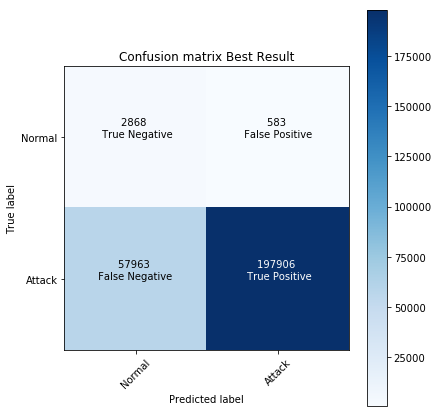

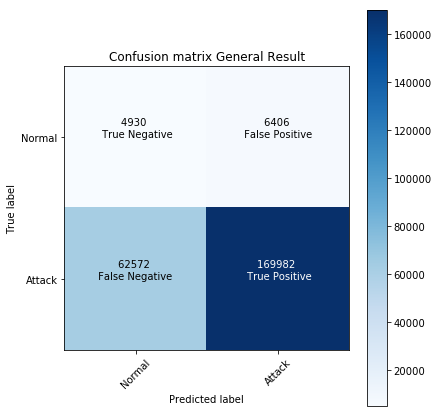

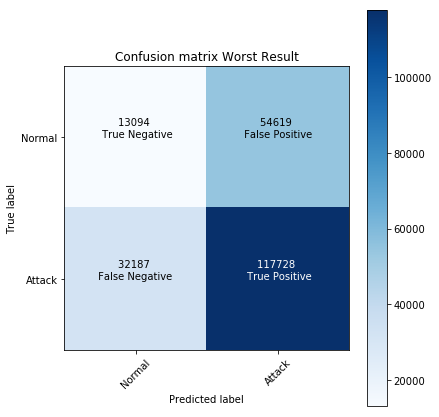

In [49]:
all_scenarios_fcn = evaluate("Fully Connected Network", past_scores, predictions)

In [14]:
psg = past_scores.sort_values(by='f1_score', ascending=False).groupby(by=['no_of_features', 'hidden_layers'])
df = psg.first().sort_values(by='f1_score', ascending=False)

In [40]:
psg.nth(int(psg.size()[0]/2)).sort_values(by='f1_score', ascending=False)

,,f1_score,key,test_score,time_taken,train_score
no_of_features,hidden_layers,,,,,
4,1,0.8313,20151202,0.7172,15.6686,0.9050
1,1,0.8299,20151205,0.7118,20.0412,0.9218
8,1,0.8195,20151211,0.6966,16.0623,0.8827
42,1,0.7896,20151201,0.6612,15.0928,0.8939
16,1,0.6932,20151221,0.5365,14.8755,0.8212
42,3,0.1697,20151214,0.1062,19.9123,0.7542
4,3,0.0006,20151229,0.0275,15.1157,0.7374
8,3,0.0002,20151209,0.0178,15.3861,0.6983
1,3,0.0000,20151229,0.0272,15.6119,0.7654


62

In [ ]:
hidden = df['hidden_layers']
epoch = df['epoch']
nof = df['no_of_features']
